In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import sys
sys.path.insert(0, '../data_prep')
from sqlite_utils import select_statement_to_df, df_to_table, table_to_df
import shap

In [2]:
all_features_query = """

WITH BASE_TABLE AS (
    
      SELECT
      
        a.FILM_ID
        ,c.FILM_TITLE
        ,d.FILM_GENRE
        ,e.FILM_RATING
        ,f.FILM_RATING_SCALED
        ,CASE WHEN f.FILM_RATING_SCALED IS NOT NULL THEN 1 ELSE 0 END AS RATED
      
      FROM ALL_FILMS a
      LEFT JOIN CONTENT_TYPE b
      ON a.FILM_ID = b.FILM_ID
      LEFT JOIN FILM_TITLE c
      ON a.FILM_ID = c.FILM_ID
      LEFT JOIN FILM_GENRE d
      ON a.FILM_ID = d.FILM_ID
      LEFT JOIN FILM_LETTERBOXD_STATS e
      ON a.FILM_ID = e.FILM_ID
      LEFT JOIN PERSONAL_RATING f
      ON a.FILM_ID = f.FILM_ID
      
      WHERE CONTENT_TYPE = 'movie'
      
    )
   
    SELECT

      a.FILM_ID
      ,b.FILM_TITLE
      ,c.FILM_WATCH_COUNT
      ,g.TOP_250_POSITION AS FILM_TOP_250
      ,c.FILM_RATING
      ,COALESCE(1.0*c.FILM_LIKES_COUNT/c.FILM_WATCH_COUNT, 0.0) AS LIKES_PER_WATCH
      ,COALESCE(1.0*c.FILM_FAN_COUNT/c.FILM_WATCH_COUNT, 0.0) AS FANS_PER_WATCH
      ,d.FILM_RUNTIME
      ,f.FILM_YEAR
      ,e.ALL_FILM_GENRES
    
    FROM ALL_FEATURE_FILMS a
    LEFT JOIN FILM_TITLE b
    ON a.FILM_ID = b.FILM_ID
    LEFT JOIN FILM_LETTERBOXD_STATS c
    ON a.FILM_ID = c.FILM_ID
    LEFT JOIN FILM_RUNTIME d
    ON a.FILM_ID = d.FILM_ID
    LEFT JOIN FILM_GENRE e
    ON a.FILM_ID = e.FILM_ID
    LEFT JOIN FILM_YEAR f
    ON a.FILM_ID = f.FILM_ID
    LEFT JOIN FILM_LETTERBOXD_TOP_250 g
    ON a.FILM_ID = g.FILM_ID

"""

keyword_query = """

WITH BASE_TABLE AS (
    
    SELECT
    
        a.FILM_ID
        ,c.FILM_TITLE
        ,d.KEYWORD
        ,d.KEYWORD_ID
        ,e.FILM_RATING
        ,f.FILM_RATING_SCALED
        ,CASE WHEN f.FILM_RATING_SCALED IS NOT NULL THEN 1 ELSE 0 END AS RATED
    
    FROM ALL_FEATURE_FILMS a
    LEFT JOIN CONTENT_TYPE b
    ON a.FILM_ID = b.FILM_ID
    LEFT JOIN FILM_TITLE c
    ON a.FILM_ID = c.FILM_ID
    LEFT JOIN FILM_KEYWORDS d
    ON a.FILM_ID = d.FILM_ID
    LEFT JOIN FILM_LETTERBOXD_STATS e
    ON a.FILM_ID = e.FILM_ID
    LEFT JOIN PERSONAL_RATING f
    ON a.FILM_ID = f.FILM_ID
    
    WHERE b.CONTENT_TYPE = 'movie'
    
    )
    
, SCORE_TABLE AS (

    SELECT

    KEYWORD_ID
    ,KEYWORD
    ,AVG(FILM_RATING) AS MEAN_RATING
    ,AVG(FILM_RATING_SCALED) AS MY_MEAN_RATING
    ,AVG(FILM_RATING_SCALED) - AVG(FILM_RATING) AS MY_VARIANCE
    ,((AVG(FILM_RATING_SCALED) - AVG(FILM_RATING)) * ((SUM(RATED)+0.0)/COUNT(*))) AS VARIANCE_SCORE
    ,COUNT(*) AS KEYWORD_COUNT
    ,SUM(RATED) AS MY_RATING_COUNT
    ,(SUM(RATED)+0.0)/COUNT(*) AS SCALER
    
    FROM BASE_TABLE
    
    GROUP BY KEYWORD
    
    HAVING KEYWORD_COUNT >= 30
    AND SCALER >= 0.2
    AND MY_RATING_COUNT >= 3
    --ORDER BY MEAN_RATING DESC
    --ORDER BY KEYWORD_COUNT DESC
    --ORDER BY MY_VARIANCE DESC
    --ORDER BY VARIANCE_SCORE DESC
    --ORDER BY MY_MEAN_RATING DESC
    --ORDER BY VARIANCE_SCORE DESC
)

SELECT
    a.FILM_ID
    ,a.KEYWORD_ID
    ,b.KEYWORD
    
FROM FILM_KEYWORDS a
LEFT JOIN SCORE_TABLE b
ON a.KEYWORD_ID = b.KEYWORD_ID

WHERE b.KEYWORD_ID IS NOT NULL

"""

my_rating_query = """

    SELECT
         FILM_ID
        ,FILM_RATING_SCALED
    FROM PERSONAL_RATING

"""

director_rating_query = """

WITH BASE_TABLE AS (

    SELECT

        a.FILM_ID
        ,d.FILM_TITLE
        ,b.PERSON_ID
        ,e.PERSON_NAME AS DIRECTOR_NAME
        ,CASE WHEN c.FILM_ID IS NULL THEN 0 ELSE 1 END AS WATCHED
        ,f.FILM_RATING_SCALED
        ,CASE WHEN f.FILM_RATING_SCALED IS NULL THEN 0 ELSE 1 END AS RATED

    FROM ALL_FEATURE_FILMS a

    LEFT JOIN FILM_CREW b
    ON a.FILM_ID = b.FILM_ID

    LEFT JOIN WATCHED c
    ON a.FILM_ID = c.FILM_ID

    LEFT JOIN FILM_TITLE d
    ON a.FILM_ID = d.FILM_ID

    LEFT JOIN PERSON_INFO e
    ON b.PERSON_ID = e.PERSON_ID

    LEFT JOIN PERSONAL_RATING f
    ON a.FILM_ID = f.FILM_ID

    WHERE b.JOB = 'Director'
        
    )
      
, DIRECTOR_RATINGS AS (

	SELECT
      
       PERSON_ID
	  ,DIRECTOR_NAME
      ,COUNT(*) AS TOTAL_FILMS
      ,SUM(WATCHED) AS FILMS_WATCHED
      ,AVG(WATCHED) AS PERCENT_WATCHED
      ,AVG(FILM_RATING_SCALED) AS MEAN_RATING
      ,SUM(RATED) AS FILMS_RATED
      ,AVG(RATED) AS PERCENT_RATED
      
    FROM BASE_TABLE
    
    GROUP BY PERSON_ID, DIRECTOR_NAME

    HAVING TOTAL_FILMS >= 3
    AND FILMS_WATCHED > 1
    AND FILMS_RATED > 1
    AND MEAN_RATING NOT NULL
    AND PERCENT_RATED >= .2
    
 	)
, DIRECTOR_WATCH_STATS AS (

	SELECT
      
       PERSON_ID
	  ,DIRECTOR_NAME
      ,COUNT(*) AS TOTAL_FILMS
      ,AVG(WATCHED) AS PERCENT_WATCHED
      
    FROM BASE_TABLE
    
    GROUP BY PERSON_ID, DIRECTOR_NAME
    
 	)

, MEAN_RATING AS ( SELECT AVG(MEAN_RATING)AS MEAN_TOTAL_RATING FROM DIRECTOR_RATINGS )

, FILM_DIRECTOR_LEVEL AS (

	SELECT
		
		 a.FILM_ID
		,a.FILM_TITLE
		,a.PERSON_ID
		,a.DIRECTOR_NAME
		,COALESCE(b.MEAN_RATING, (SELECT 0.8*MEAN_TOTAL_RATING FROM MEAN_RATING)) AS DIRECTOR_MEAN_RATING
		,COALESCE(c.TOTAL_FILMS, 0) AS DIRECTOR_TOTAL_FILMS
		,COALESCE(c.PERCENT_WATCHED, 0) AS DIRECTOR_PERCENT_WATCHED
		
	 FROM BASE_TABLE a
	 LEFT JOIN DIRECTOR_RATINGS b 
	 ON a.PERSON_ID = b.PERSON_ID
	 LEFT JOIN DIRECTOR_WATCH_STATS c
	 ON a.PERSON_ID = c.PERSON_ID
	 
	 )
	 
SELECT
	
	 FILM_ID
	,AVG(DIRECTOR_MEAN_RATING) AS DIRECTOR_MEAN_RATING
	,AVG(DIRECTOR_TOTAL_FILMS) AS DIRECTOR_TOTAL_FILMS
	,AVG(DIRECTOR_PERCENT_WATCHED) AS DIRECTOR_PERCENT_WATCHED

FROM FILM_DIRECTOR_LEVEL

GROUP BY FILM_ID, FILM_TITLE

"""

top_actor_film_level_query = """

WITH BASE_TABLE AS (

    SELECT

        a.FILM_ID
        ,d.FILM_TITLE
        ,b.PERSON_ID
        ,e.PERSON_NAME AS ACTOR_NAME
        ,CASE WHEN c.FILM_ID IS NULL THEN 0 ELSE 1 END AS WATCHED
        ,CASE WHEN f.FILM_RATING_SCALED IS NOT NULL THEN 1 ELSE 0 END AS RATED
        ,f.FILM_RATING_SCALED

    FROM ALL_FEATURE_FILMS a
    
    LEFT JOIN FILM_CAST b
    ON a.FILM_ID = b.FILM_ID
    
    LEFT JOIN WATCHED c
    ON a.FILM_ID = c.FILM_ID
    
    LEFT JOIN FILM_TITLE d
    ON a.FILM_ID = d.FILM_ID

    LEFT JOIN PERSON_INFO e
    ON b.PERSON_ID = e.PERSON_ID

    LEFT JOIN PERSONAL_RATING f
    ON a.FILM_ID = f.FILM_ID

    WHERE e.PERSON_NAME IS NOT NULL
    
    )
    
, ACTOR_TABLE AS (

    SELECT

    PERSON_ID
    ,SUM(WATCHED) AS TOTAL_WATCHED
    
    FROM BASE_TABLE
    
    GROUP BY PERSON_ID
    
    HAVING TOTAL_WATCHED >= 20
)

SELECT
    
     a.FILM_ID
    ,a.PERSON_ID
    ,a.ACTOR_NAME
    ,1 AS ACTOR_IN_FILM
    
FROM BASE_TABLE a
INNER JOIN ACTOR_TABLE b
ON a.PERSON_ID = b.PERSON_ID

"""

def scale_col(df, column, suffix='', a=0, b=1):
    col_min = df[column].min()
    col_max = df[column].max()
    col_range = (col_max - col_min)
    df[column+suffix] = ((df[column] - col_min) / col_range) * (b - a) + a
    return df


In [3]:
def get_valid_cols(film_id, shap_df, min_shap_val=0.001):
    filmid_shap_df = shap_df[shap_df['FILM_ID']==film_id].reset_index(drop=True)
    valid_cols = []
    for col in filmid_shap_df.columns:
        shap_val = filmid_shap_df[col][0]
        if isinstance(shap_val, str):
            col_valid = False
        elif np.isnan(shap_val):
            col_valid = False
        elif abs(shap_val) < min_shap_val:
            col_valid = False
        elif col == 'BASE_VALUE':
            col_valid = True
        else:
            col_valid = True
        if col_valid:
            valid_cols.append(col)
    return valid_cols

def create_dual_df(film_id, pred_df, shap_df, valid_cols):
    film_title = pred_df[pred_df['FILM_ID']==film_id]['FILM_TITLE'].values[0]
    dual_df = pd.concat([pred_df[pred_df['FILM_ID']==film_id], shap_df[shap_df['FILM_ID']==film_id]])
    dual_df['FILM_TITLE'] = dual_df['FILM_TITLE'].fillna(film_title)
    dual_df['ALGO_SCORE'] = dual_df['ALGO_SCORE'].fillna(dual_df['ALGO_SCORE'].max())
    dual_df = dual_df[valid_cols]
    dual_df.insert(2, 'INFO', ['FEATURE_VALUE', 'SHAP_VALUE'])
    dual_df = dual_df.reset_index(drop=True)
    return dual_df

def return_comparison_df(film_ids, min_shap_val=0.001, decimal_places=3):
    pred_df = table_to_df(table_name='FILM_ALGO_SCORE')
    shap_df = table_to_df(table_name='FILM_SHAP_VALUES')
    valid_cols = [get_valid_cols(x, shap_df, min_shap_val=min_shap_val) for x in film_ids]
    valid_cols = list(set([col for valid_col_list in valid_cols for col in valid_col_list]))
    valid_cols = ['FILM_ID', 'FILM_TITLE', 'ALGO_SCORE'] + valid_cols
    valid_cols = [x for x in pred_df.columns if x in valid_cols]
    valid_cols.append('BASE_VALUE')
    all_dfs = []
    for n, film_id in enumerate(film_ids):
        dual_df = create_dual_df(film_id, pred_df, shap_df, valid_cols)
        melted_df = pd.melt(dual_df, id_vars=['FILM_ID', 'FILM_TITLE', 'INFO'])
        pivoted_df = melted_df.drop('FILM_ID', axis=1).pivot(index='variable', columns=['FILM_TITLE', 'INFO'], values='value').reset_index()
        pivoted_df.columns = [' '.join(col) for col in pivoted_df.columns]
        if n > 0:
            pivoted_df = pivoted_df.drop('variable ', axis=1)
        all_dfs.append(pivoted_df)
    comparison_df = pd.concat(all_dfs, axis=1)
    if len(film_ids) > 1:
        comparison_df['VAR'] = comparison_df[comparison_df.columns[4]] - comparison_df[comparison_df.columns[2]]
        comparison_df['ABS_VAR'] = comparison_df['VAR'].abs()
        comparison_df = comparison_df.sort_values('ABS_VAR', ascending=False)
    else:
        comparison_df = comparison_df.sort_values(comparison_df.columns[2], ascending=False)
    return comparison_df.round(decimal_places)

In [4]:
eligible_watchlist_df = select_statement_to_df(all_features_query)
director_rating_df = select_statement_to_df(director_rating_query)
eligible_watchlist_df = eligible_watchlist_df.merge(director_rating_df, how='left', on='FILM_ID')
eligible_watchlist_df = pd.concat([eligible_watchlist_df, eligible_watchlist_df['ALL_FILM_GENRES'].str.get_dummies(sep='/')], axis=1).drop('ALL_FILM_GENRES', axis=1)
keyword_df = select_statement_to_df(keyword_query)
keyword_df['COUNT'] = 1
keyword_df_wide = pd.pivot_table(keyword_df, values='COUNT', index=['FILM_ID'], columns=['KEYWORD']).fillna(0).reset_index()
eligible_watchlist_df = eligible_watchlist_df.merge(keyword_df_wide, how='left', on='FILM_ID')
top_actor_film_level_df = select_statement_to_df(top_actor_film_level_query)
actor_lookup_df = top_actor_film_level_df.groupby(['PERSON_ID', 'ACTOR_NAME']).count().reset_index()
actor_lookup_dict = {id:name for id, name in zip(actor_lookup_df['PERSON_ID'], actor_lookup_df['ACTOR_NAME'])}
top_actor_film_level_df_wide = pd.pivot_table(top_actor_film_level_df, values='ACTOR_IN_FILM', index=['FILM_ID'], columns='PERSON_ID').fillna(0)
top_actor_film_level_df_wide.columns = [actor_lookup_dict.get(x, x) for x in top_actor_film_level_df_wide.columns]
eligible_watchlist_df['FILM_TOP_250'] = eligible_watchlist_df['FILM_TOP_250'].fillna(266)
eligible_watchlist_df.insert(4, 'FILM_IS_TOP_250', np.where(eligible_watchlist_df['FILM_TOP_250']<=250, 1, 0))
eligible_watchlist_df = eligible_watchlist_df.merge(top_actor_film_level_df_wide, how='left', on='FILM_ID').fillna(0)
eligible_watchlist_df['FILM_RATING'] = eligible_watchlist_df['FILM_RATING'].fillna(2.0)
eligible_watchlist_df = eligible_watchlist_df.fillna(0)
my_rating_df = select_statement_to_df(my_rating_query)
rating_features_df = eligible_watchlist_df.merge(my_rating_df, how='left', on='FILM_ID')
rating_features_df['I_VS_LB'] = rating_features_df['FILM_RATING_SCALED'] - rating_features_df['FILM_RATING']
rated_features = rating_features_df[rating_features_df['FILM_RATING_SCALED'].notnull()].reset_index(drop=True)
unrated_features = rating_features_df[rating_features_df['FILM_RATING_SCALED'].isnull()].reset_index(drop=True)
rating_features_df.head()

,FILM_ID,FILM_TITLE,FILM_WATCH_COUNT,FILM_TOP_250,FILM_IS_TOP_250,FILM_RATING,LIKES_PER_WATCH,FANS_PER_WATCH,FILM_RUNTIME,FILM_YEAR,...,Michael Fassbender,Idris Elba,Jack Angel,Alan Tudyk,Thomas Rosales Jr.,Bob Bergen,Mickie McGowan,Sherry Lynn,FILM_RATING_SCALED,I_VS_LB
0,f_01ZLI,Jumanji,1019548,266.0,0,3.61,0.185029,0.001206,104,1995,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.627049,-0.982951
1,f_01UTC,Fatal Attraction,107958,266.0,0,3.46,0.164573,0.001315,119,1987,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.870930,0.410930
2,f_020E4,Punch-Drunk Love,548617,266.0,0,3.99,0.327779,0.016667,96,2002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.056391,-0.933609
3,f_01TBi,Altered States,68703,266.0,0,3.66,0.277994,0.004512,102,1980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.115116,0.455116
4,f_0t4EQ,Death to 2020,83897,266.0,0,2.71,0.110075,0.000036,71,2020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [5]:
def analyse_col(col_name):
    agg_df = rated_features.groupby(col_name).agg({'FILM_ID':'count', 'FILM_RATING':'mean', 'FILM_RATING_SCALED':'mean', 'I_VS_LB':'mean'})
    display(agg_df)
    all_titles = list(rated_features[rated_features[col_name] == 1]['FILM_TITLE'].values)
    display(', '.join(all_titles))
    if len(agg_df) <= 5:
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))
        ax = ax.flatten()
        sns.histplot(rated_features, x='FILM_RATING_SCALED', hue=col_name, kde=True, ax=ax[0])
        sns.ecdfplot(rated_features, x='FILM_RATING_SCALED', hue=col_name, ax=ax[1])
        sns.histplot(rated_features, x='I_VS_LB', hue=col_name, kde=True, ax=ax[2])
        sns.ecdfplot(rated_features, x='I_VS_LB', hue=col_name, ax=ax[3])
    else:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax = ax.flatten()
        sns.histplot(rating_features_df, x=col_name, kde=True, ax=ax[0])
        sns.ecdfplot(rating_features_df, x=col_name, ax=ax[1])

,FILM_ID,FILM_RATING,FILM_RATING_SCALED,I_VS_LB
horror,,,,
0,681,3.431645,3.389286,-0.042359
1,549,3.076594,3.260732,0.184138


"Altered States, The Skin I Live In, The Hunt, Ready or Not, The Nun, Paranormal Activity, The Faculty, Sea Fever, Spiral, I Know What You Did Last Summer, The Blob, Drag Me to Hell, Village of the Damned, House of Wax, Urban Legend, House of 1000 Corpses, Martyrs, Silent Hill, The Ghoul, Henry: Portrait of a Serial Killer, Frankenstein, The Invisible Man, Jennifer's Body, Alien, The Thing, Get Out, Jaws, It Follows, Halloween, Friday the 13th, The Texas Chain Saw Massacre, Friday the 13th Part 2, Creature from the Black Lagoon, Scream, Evil Dead, Audition, Orphan, The Autopsy of Jane Doe, Friday the 13th: A New Beginning, Gerald's Game, Suspiria, Hellbound: Hellraiser II, Candyman, Possum, The Brood, Midsommar, The Lighthouse, Us, Black Swan, Annihilation, Halloween, Apostle, Jigsaw, The Neon Demon, The Conjuring 2, The Purge: Election Year, Resident Evil: The Final Chapter, Terrifier, 31, The Witch, Bone Tomahawk, Circle, What We Do in the Shadows, Creep, The Purge: Anarchy, Annabell

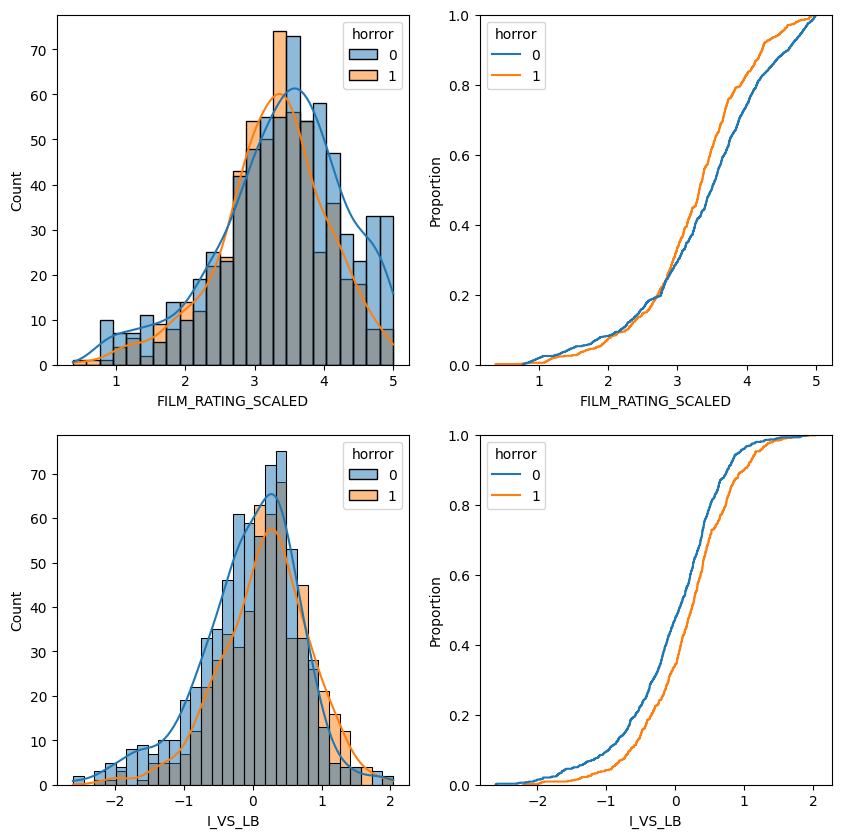

In [6]:
analyse_col('horror')

In [31]:
non_features = ['FILM_ID',
                'FILM_TITLE',
                'FILM_RUNTIME',
                'FILM_RATING_SCALED',
                'I_VS_LB',
                ]
model_features = [x for x in unrated_features.columns if x not in non_features]
delete_cols = []
for col in model_features:
    if len(rated_features[col].unique()) == 2:
        col_sum = rated_features[col].sum()
        if col_sum < 5:
            delete_cols.append(col)
print(delete_cols)
model_features = [x for x in model_features if x not in delete_cols]
target = 'I_VS_LB'
X_train = rated_features[model_features]
y_train = rated_features[[target]]
print('Data gathering complete!')
print('Scaling features...')
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
print('Features Scaled!')
print('Training model...')
valid_model_types = ['xgboost', 'decision_tree', 'linear_regression']
model_type = 'xgboost'
if model_type == 'xgboost':
    model = XGBRegressor(min_child_weight=3)
elif model_type == 'decision_tree':
    model = DecisionTreeRegressor(min_samples_leaf=3)
elif model_type == 'linear_regression':
    model = LinearRegression()
model.fit(X_train, y_train)
print('Model train complete!')
print('Making predictions...')
X_pred = unrated_features[model_features]
X_pred = scaler.transform(X_pred)
pred_df = unrated_features.copy()
pred_df[target+'_PRED'] = model.predict(X_pred)
print('Predictions complete!')
pred_df['FILM_RATING_PRED'] = pred_df['FILM_RATING'] + pred_df[target+'_PRED']
pred_df = scale_col(pred_df, 'FILM_RATING_PRED', a=0, b=5)
pred_df = scale_col(pred_df, target+'_PRED', a=0, b=1)

['tv-movie', 'Elizabeth Banks']
Data gathering complete!
Scaling features...
Features Scaled!
Training model...
Model train complete!
Making predictions...
Predictions complete!


(array([  6.,  21.,  37.,  75., 198., 309., 362., 166.,  45.,  11.]),
 array([-2.60285714, -2.13871096, -1.67456478, -1.2104186 , -0.74627243,
        -0.28212625,  0.18201993,  0.64616611,  1.11031229,  1.57445847,
         2.03860465]),
 <BarContainer object of 10 artists>)

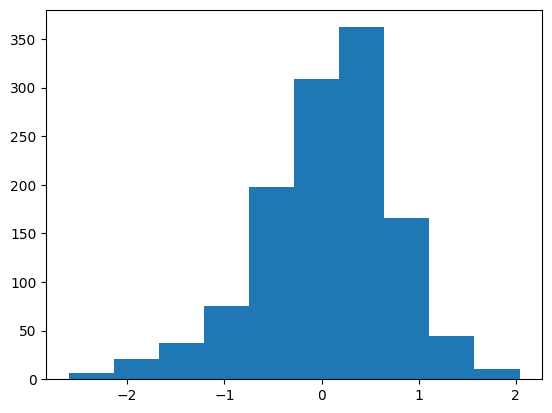

In [27]:
plt.hist(y_train)

In [34]:
pred_df['FILM_RATING_PRED'].describe()

count    16282.000000
mean         3.388776
std          0.572889
min          0.000000
25%          3.080183
50%          3.430890
75%          3.754619
max          5.000000
Name: FILM_RATING_PRED, dtype: float64

In [33]:
pred_df.sort_values(target+'_PRED', ascending=False).head(50)

,FILM_ID,FILM_TITLE,FILM_WATCH_COUNT,FILM_TOP_250,FILM_IS_TOP_250,FILM_RATING,LIKES_PER_WATCH,FANS_PER_WATCH,FILM_RUNTIME,FILM_YEAR,...,Jack Angel,Alan Tudyk,Thomas Rosales Jr.,Bob Bergen,Mickie McGowan,Sherry Lynn,FILM_RATING_SCALED,I_VS_LB,I_VS_LB_PRED,FILM_RATING_PRED
504,f_00F2G,Cowboys & Aliens,202949,266.0,0,2.32,0.065736,0.000103,119,2011,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.000000,4.181967
199,f_0bDw2,The Predator,168991,266.0,0,2.12,0.087389,0.000136,107,2018,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.997288,4.034757
1696,f_0bO28,Blair Witch,142918,266.0,0,2.36,0.096657,0.000693,89,2016,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.976158,4.141455
202,f_0f9a4,Rampage,210881,266.0,0,2.36,0.094072,0.000256,107,2018,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.975694,4.140123
853,f_01Uea,Freddy's Dead: The Final Nightmare,93125,266.0,0,2.12,0.110518,0.000161,89,1991,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.971171,3.959831
404,f_02CWU,The Wolverine,669878,266.0,0,2.96,0.123524,0.000166,126,2013,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.953175,4.493811
618,f_0290M,Ghost Rider,340464,266.0,0,2.33,0.086961,0.000734,114,2007,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.952294,4.052077
560,f_020IA,The Lovely Bones,420265,266.0,0,3.32,0.176408,0.005206,136,2009,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.951136,4.738935
405,f_00uYE,Star Trek Into Darkness,415062,266.0,0,3.33,0.157613,0.000636,132,2013,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.946085,4.731416
152,f_0eJTW,Scary Stories to Tell in the Dark,259629,266.0,0,2.76,0.149498,0.000474,108,2019,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.942121,4.322669


(array([  6.,  21.,  37.,  75., 198., 309., 362., 166.,  45.,  11.]),
 array([-2.60285714, -2.13871096, -1.67456478, -1.2104186 , -0.74627243,
        -0.28212625,  0.18201993,  0.64616611,  1.11031229,  1.57445847,
         2.03860465]),
 <BarContainer object of 10 artists>)

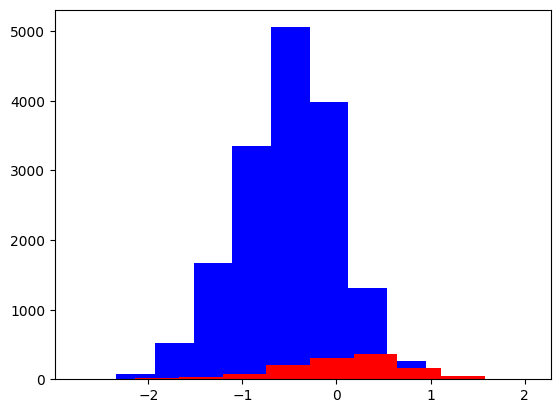

In [29]:
plt.hist(pred_df['I_VS_LB_PRED'], color='blue')
plt.hist(y_train, color='red')

In [42]:
pred_df.sort_values('I_VS_LB_PRED', ascending=False).head(50)

,FILM_ID,FILM_TITLE,FILM_WATCH_COUNT,FILM_TOP_250,FILM_IS_TOP_250,FILM_RATING,LIKES_PER_WATCH,FANS_PER_WATCH,FILM_RUNTIME,FILM_YEAR,...,Jack Angel,Alan Tudyk,Thomas Rosales Jr.,Bob Bergen,Mickie McGowan,Sherry Lynn,FILM_RATING_SCALED,I_VS_LB,I_VS_LB_PRED,FILM_RATING_PRED
504,f_00F2G,Cowboys & Aliens,202949,266.0,0,2.32,0.065736,0.000103,119,2011,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.000000,4.181967
199,f_0bDw2,The Predator,168991,266.0,0,2.12,0.087389,0.000136,107,2018,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.997288,4.034757
1696,f_0bO28,Blair Witch,142918,266.0,0,2.36,0.096657,0.000693,89,2016,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.976158,4.141455
202,f_0f9a4,Rampage,210881,266.0,0,2.36,0.094072,0.000256,107,2018,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.975694,4.140123
853,f_01Uea,Freddy's Dead: The Final Nightmare,93125,266.0,0,2.12,0.110518,0.000161,89,1991,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.971171,3.959831
404,f_02CWU,The Wolverine,669878,266.0,0,2.96,0.123524,0.000166,126,2013,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.953175,4.493811
618,f_0290M,Ghost Rider,340464,266.0,0,2.33,0.086961,0.000734,114,2007,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.952294,4.052077
560,f_020IA,The Lovely Bones,420265,266.0,0,3.32,0.176408,0.005206,136,2009,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.951136,4.738935
405,f_00uYE,Star Trek Into Darkness,415062,266.0,0,3.33,0.157613,0.000636,132,2013,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.946085,4.731416
152,f_0eJTW,Scary Stories to Tell in the Dark,259629,266.0,0,2.76,0.149498,0.000474,108,2019,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.942121,4.322669


In [35]:
final_df = pd.concat([pred_df, rated_features], axis=0).reset_index(drop=True)
print('Calculating SHAP values...')
if model_type == 'xgboost' or model_type == 'decision_tree':
    explainer = shap.TreeExplainer(model, X_train)
elif model_type == 'linear_regression':
    explainer = shap.LinearExplainer(model, X_train)
# shap_values = explainer.Explainer(X_pred)
shap_values = explainer.shap_values(X_pred)
explainer_df = pd.DataFrame(shap_values, columns=model_features)
explainer_df.insert(0, 'FILM_ID', pred_df['FILM_ID'])

Calculating SHAP values...


 96%|=================== | 15703/16282 [00:25<00:00]       

In [36]:
model_type

'xgboost'

In [43]:
tmp_film_id = 'f_00F2G'
tmp = explainer_df[explainer_df['FILM_ID']==tmp_film_id].drop('FILM_ID', axis=1)
tmp2 = tmp.loc[:, (abs(tmp) > 0.01).any(axis=0)].T.reset_index()
tmp2.columns = ['col_name', 'col_shap']
tmp3 = unrated_features[unrated_features['FILM_ID']==tmp_film_id].T.reset_index()
tmp3.columns = ['col_name', 'col_val']
tmp4 = tmp3.merge(tmp2, how='inner', on='col_name')
tmp4.sort_values('col_shap')

,col_name,col_val,col_shap
2,LIKES_PER_WATCH,0.065736,-0.160660
13,horror,0,-0.046158
7,DIRECTOR_PERCENT_WATCHED,0.777778,-0.034257
6,DIRECTOR_TOTAL_FILMS,9.0,-0.018779
14,mystery,0,-0.015932
12,fantasy,0,-0.011607
8,action,1,0.010208
16,thriller,1,0.011855
10,crime,0,0.014161
11,family,0,0.017888


In [44]:
tmp4.sum()

col_name    FILM_WATCH_COUNTFILM_RATINGLIKES_PER_WATCHFANS...
col_val                                         204982.837765
col_shap                                              1.29671
dtype: object

In [252]:
pred_df.sort_values('FILM_RATING_PRED')

,FILM_ID,FILM_TITLE,FILM_WATCH_COUNT,FILM_TOP_250,FILM_IS_TOP_250,FILM_RATING,LIKES_PER_WATCH,FANS_PER_WATCH,FILM_RUNTIME,FILM_YEAR,...,Jack Angel,Alan Tudyk,Thomas Rosales Jr.,Bob Bergen,Mickie McGowan,Sherry Lynn,FILM_RATING_SCALED,I_VS_LB,I_VS_LB_PRED,FILM_RATING_PRED
6651,f_04rmU,Sunday Lovers,118,266.0,0,0.00,0.084746,0.000000,125,1980,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-1.795272,0.000000
11764,f_00M24,The Treatment,185,266.0,0,0.00,0.070270,0.000000,86,2006,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-1.785493,0.001418
13428,f_00LvO,A Further Gesture,84,266.0,0,0.00,0.071429,0.000000,96,1997,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-1.737286,0.008407
14026,f_04hfY,Two Tickets to Broadway,246,266.0,0,0.00,0.105691,0.000000,106,1951,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-1.731155,0.009296
12230,f_0hhJq,The Brawler,178,266.0,0,0.00,0.073034,0.000000,95,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-1.588463,0.029983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,f_01skk,Inception,3060548,266.0,0,4.19,0.404516,0.017288,148,2010,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.767369,0.979001
27,f_02aGY,Terminator 2: Judgment Day,860837,266.0,0,4.28,0.306057,0.012814,137,1991,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.732608,0.987010
117,f_0b8wK,Blade Runner 2049,1593560,266.0,0,4.13,0.378853,0.025117,164,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.910138,0.991001
104,f_04VZ8,Interstellar,3036075,266.0,0,4.32,0.452177,0.052233,169,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.771972,0.998516


In [40]:
ex

0.0405559266593475

In [39]:

# import ipdb; ipdb.set_trace()
try:
    ex = explainer.expected_value[0]
except:
    ex = explainer.expected_value
explainer_df.insert(1, 'BASE_VALUE', ex)
explainer_df['PREDICTION'] = explainer_df.sum(axis=1)
explainer_df = explainer_df.merge(pred_df[['FILM_ID', 'ALGO_SCORE']], how='left', on='FILM_ID')
explainer_df['SCALER'] = explainer_df['ALGO_SCORE'] / explainer_df['PREDICTION']
explainer_df = explainer_df.drop('FILM_ID', axis=1).mul(explainer_df['SCALER'], axis=0).drop(['ALGO_SCORE', 'SCALER'], axis=1) 
explainer_df.insert(0, 'FILM_ID', pred_df['FILM_ID'])
explainer_df = explainer_df.loc[:, (explainer_df != 0).any(axis=0)]
print('SHAP values calculated!')

C:\Users\tom\AppData\Local\Temp\ipykernel_60388\1129709933.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  explainer_df['PREDICTION'] = explainer_df.sum(axis=1)


KeyError: "['ALGO_SCORE'] not in index"

In [235]:
X_train

array([[ 0.93282623,  0.07302188, -0.08215985, ..., -0.09325048,
        -0.10319204, -0.10319204],
       [-0.51551018,  0.07302188, -0.08215985, ..., -0.09325048,
        -0.10319204, -0.10319204],
       [ 0.17525549,  0.07302188, -0.08215985, ..., -0.09325048,
        -0.10319204, -0.10319204],
       ...,
       [-0.61828158,  0.07302188, -0.08215985, ..., -0.09325048,
        -0.10319204, -0.10319204],
       [-0.69483497,  0.07302188, -0.08215985, ..., -0.09325048,
        -0.10319204, -0.10319204],
       [-0.55662786,  0.07302188, -0.08215985, ..., -0.09325048,
        -0.10319204, -0.10319204]])